In [1]:
!pip install pypdf pypdf[full] pymupdf llama-index-core llama-parse llama-index-readers-file langchain-huggingface marker-pdf

### Pdf Parsing

In [150]:
from pypdf import PdfReader
reader = PdfReader("attention.pdf")
page = reader.pages[3]
print(page.extract_text())

Scaled Dot-Product Attention
 Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key.
3.2.1 Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as:
Attention(Q, K, V) = softmax(QKT
√dk
)V (1)
The two most commonly used attention functions are additive attention [2], a

In [151]:
documents_naive = []
for i in range(len(reader.pages)):
    doc = reader.pages[i].extract_text(extraction_mode="layout")
    documents_naive.append(doc)

Rotated text discovered. Output will be incomplete.


In [152]:
# extract text in a fixed width format that closely adheres to the rendered
# layout in the source pdf
print(page.extract_text(extraction_mode="layout"))

            Scaled Dot-Product Attention                                     Multi-Head Attention



















Figure 2:  (left) Scaled Dot-Product Attention.  (right) Multi-Head Attention consists of several
attention layers running in parallel.


ofthe values, wherethe weightassigned toeach valueis computedby acompatibility functionof the
query with the corresponding key.

3.2.1   Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queriesand keysof dimensiondk,and valuesof dimensiondv. Wecomputethe dotproducts ofthe
querywith allkeys, divideeach by√            dk,and applya softmaxfunctionto obtaintheweights onthe
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
intoamatrixQ . ThekeysandvaluesarealsopackedtogetherintomatricesK   andV  . Wecompute
the matrix of outputs as:


                                  Attention(      Q,K,V     ) = softmax( 

In [153]:
import fitz 
import io
from PIL import Image

# Open the PDF file
pdf_document = "report.pdf"
pdf = fitz.open(pdf_document)

# Iterate through each page
for page_number in range(len(pdf)):
    page = pdf.load_page(page_number)
    images = page.get_images(full=True)

    # Iterate through each image on the page
    for img_index, img in enumerate(images):
        xref = img[0]
        base_image = pdf.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image = Image.open(io.BytesIO(image_bytes))

        # Save the image
        image_filename = f"page_{page_number + 1}_image_{img_index + 1}.{image_ext}"
        image.save(open(image_filename, "wb"))

        print(f"Saved image: {image_filename}")

pdf.close()


Saved image: page_23_image_1.jpeg


In [67]:
# llama parser using llamacloud api to extract content from pdf
# 1000 pages free usage per day
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
# bring in our LLAMA_CLOUD_API_KEY
from dotenv import load_dotenv
import asyncio
import os
import nest_asyncio
nest_asyncio.apply()
load_dotenv()

# set up parser
parser = LlamaParse(
    result_type="markdown"  # "markdown" and "text" are available
)
# use SimpleDirectoryReader to parse our file
file_extractor = {".pdf": parser}
documents = SimpleDirectoryReader(input_files=['attention.pdf'], file_extractor=file_extractor).load_data()
print(documents)

Started parsing the file under job_id 340d1345-9f18-46d4-97eb-64e0cfa6cfc8
[Document(id_='4c58c251-400d-4799-a175-9135353e8364', embedding=None, metadata={'file_path': 'attention.pdf', 'file_name': 'attention.pdf', 'file_type': 'application/pdf', 'file_size': 2215244, 'creation_date': '2024-12-19', 'last_modified_date': '2024-12-19'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\n# Attention Is All You Need\n\narXiv:1706.03762v7 · [cs.CL] · 2 Aug 2023\n\nAshish Vaswani∗, Noam Shazeer∗, Niki Parmar∗, Jakob Uszkoreit∗\n\nGoogle Brain, Google Brain, Google Research, Google Research

In [68]:
for i in range(len(documents)):
    print(documents[i].text)
    print("----")
    print(documents[i].metadata)
    print("----")
    print(f"page number: {i+1}")

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

# Attention Is All You Need

arXiv:1706.03762v7 · [cs.CL] · 2 Aug 2023

Ashish Vaswani∗, Noam Shazeer∗, Niki Parmar∗, Jakob Uszkoreit∗

Google Brain, Google Brain, Google Research, Google Research

avaswani@google.com, noam@google.com, nikip@google.com, usz@google.com

Llion Jones∗, Aidan N. Gomez∗ †, Łukasz Kaiser∗

Google Research, University of Toronto, Google Brain

llion@google.com, aidan@cs.toronto.edu, lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

# Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attent

In [27]:
# marker downloads llm and uses it to extract content from pdf
# it is free to use for non-commercial purpose
from marker.converters.pdf import PdfConverter
from marker.renderers.markdown import MarkdownOutput
from marker.models import create_model_dict
from marker.output import text_from_rendered
from marker.config.parser import ConfigParser

config = {
    "output_format":"markdown",
}
config_parser = ConfigParser(config)

converter = PdfConverter(
    config= config_parser.generate_config_dict(),
    artifact_dict = create_model_dict(),
    processor_list = config_parser.get_processors(),
    renderer = config_parser.get_renderer()
)

rendered = converter("attention.pdf")
text,_,images = text_from_rendered(rendered)


Loaded layout model datalab-to/surya_layout0 on device cuda with dtype torch.float16
Loaded texify model to cuda with torch.float16 dtype
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded table recognition model vikp/surya_tablerec on device cuda with dtype torch.float16
Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16


Recognizing layout: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


In [28]:
print(text)

# Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

# Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

> Llion Jones∗ Google Research

llion@google.com

Google Brain noam@google.com

Noam Shazeer∗

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Niki Parmar∗ Google Research nikip@google.com

> Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Jakob Uszkoreit∗ Google Research usz@google.com

Illia Polosukhin∗ ‡ illia.polosukhin@gmail.com

# Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and con

In [48]:
rendered.metadata['table_of_contents'][0]['title']

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.'

In [195]:
import pdfplumber
import pandas as pd
pdf = pdfplumber.open("report.pdf")
for i in range(len(pdf.pages)):
    page = pdf.pages[i]
    table = page.extract_table()
    if table is not None:
        text = page.extract_text(keep_blank_chars=True)
        print(table)
        print("----")
        print(text)


[['October 1 - 31, 2023', '', '287,360', '', '$', '404.62', '', '287,360', '', '$', '10,738,584'], ['November 1 - 30, 2023', '', '2,708,477', '', '$', '447.03', '', '2,708,477', '', '$', '9,527,821'], ['December 1 - 31, 2023', '', '2,481,771', '', '$', '472.63', '', '2,481,771', '', '$', '8,354,857'], ['Total', '', '5,477,608', '', '', None, '', '5,477,608', '', '', None]]
----
Table of Contents
PART II
 
Item 5. Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities
Market Information
Our common stock is traded on the NASDAQ Global Select Market under the symbol “NFLX”.
Holders
As of December 31, 2023, there were approximately 2,728 stockholders of record of our common stock, although there is a significantly larger number
of beneficial owners of our common stock.
Dividend Policy
We have never declared or paid any cash dividends on our capital stock, and we do not currently anticipate paying any cash dividends in the foreseeable
fu

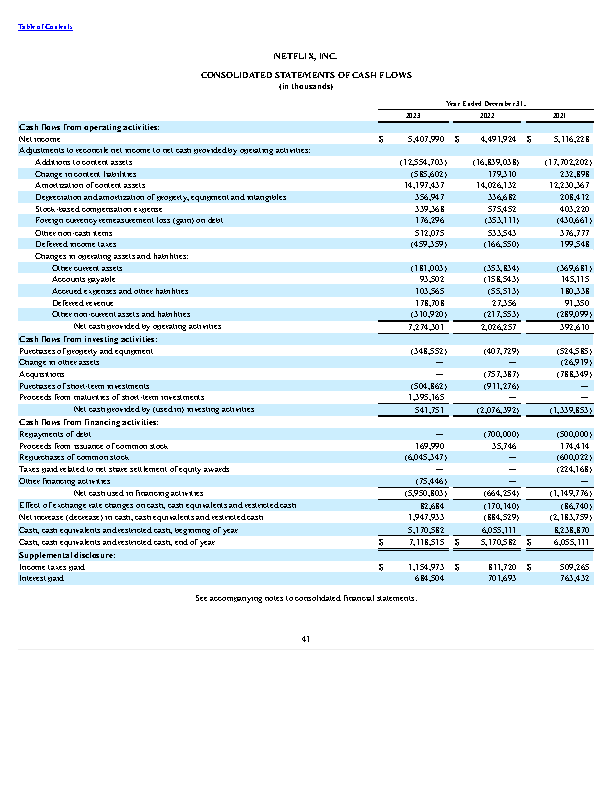

In [191]:
p0 = pdf.pages[43]
im = p0.to_image()
im

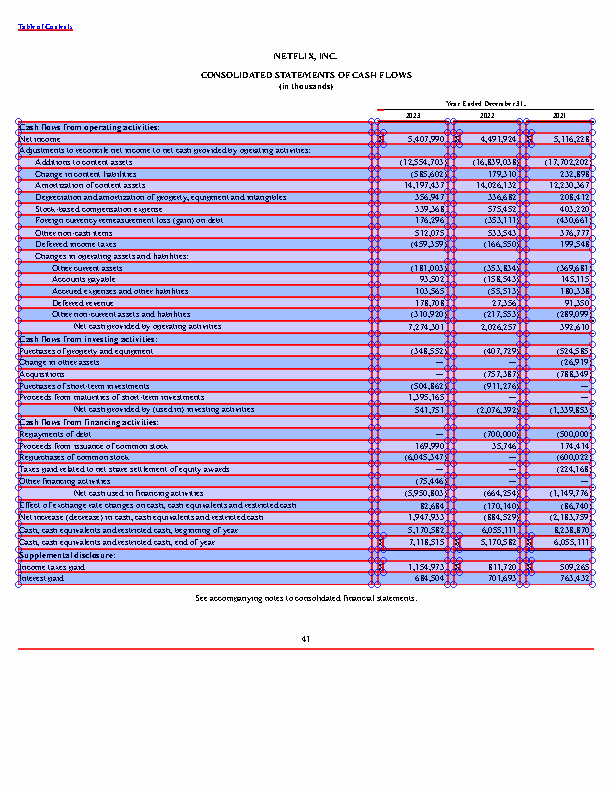

In [192]:
im.reset().debug_tablefinder()

In [193]:
text = p0.extract_text(keep_blank_chars=True,)
print(text)

Table of Contents
NETFLIX, INC.
CONSOLIDATED STATEMENTS OF CASH FLOWS
(in thousands)
   Year Ended December 31,
   2023 2022 2021
Cash flows from operating activities:
Net income $ 5,407,990  $ 4,491,924  $ 5,116,228 
Adjustments to reconcile net income to net cash provided by operating activities:
Additions to content assets (12,554,703) (16,839,038) (17,702,202)
Change in content liabilities (585,602) 179,310  232,898 
Amortization of content assets 14,197,437  14,026,132  12,230,367 
Depreciation and amortization of property, equipment and intangibles 356,947  336,682  208,412 
Stock-based compensation expense 339,368  575,452  403,220 
Foreign currency remeasurement loss (gain) on debt 176,296  (353,111) (430,661)
Other non-cash items 512,075  533,543  376,777 
Deferred income taxes (459,359) (166,550) 199,548 
Changes in operating assets and liabilities:
Other current assets (181,003) (353,834) (369,681)
Accounts payable 93,502  (158,543) 145,115 
Accrued expenses and other liabil

### Retrieval with fixed size chunking - pypdf

In [154]:
from langchain_openai import ChatOpenAI
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings


# Initialize OpenAI models
llm = ChatOpenAI(model="gpt-4o")
embedding_model = HuggingFaceEmbeddings()
# embedding_model = OpenAIEmbeddings()
# Load and preprocess documents

# Split documents into chunks for vector storage
text_splitter = CharacterTextSplitter(chunk_size=256, chunk_overlap=20)
docs = text_splitter.create_documents(documents_naive)

# Create a vector database using FAISS
vector_db = FAISS.from_documents(docs, embedding_model)

# Create a conversation chain with retrieval capabilities
retrieval_chain = ConversationalRetrievalChain.from_llm(llm, vector_db.as_retriever())

C:\Users\long8\AppData\Local\Temp\ipykernel_22764\2384133918.py:12: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding_model = HuggingFaceEmbeddings()
Created a chunk of size 323, which is longer than the specified 256
Created a chunk of size 294, which is longer than the specified 256
Created a chunk of size 1249, which is longer than the specified 256
Created a chunk of size 928, which is longer than the specified 256
Created a chunk of size 1791, which is longer than the specified 256
Created a chunk of size 1754, which is longer than the specified 256
Created a chunk of size 483, which is longer than the specified 256
Created a chunk of size 660, which is longer than the specified 256
Created a chunk of size 652, which is longer than the specified 256
Created a chunk of size 540, which is longer th

In [155]:
response = retrieval_chain.invoke({"question": "What is the score for Transformer (base model)", "chat_history": []})
pprint(response['answer'])

('The BLEU score for the Transformer (base model) on the English-to-German '
 'translation is 27.3, and for the English-to-French translation, it is 38.1.')


In [156]:
response = retrieval_chain.invoke({"question": "What is English constituency parsing Results for Zhu et al. (2013)", "chat_history": []})
pprint(response['answer'])

('The English constituency parsing results for Zhu et al. (2013) are 90.4 F1 '
 'when using WSJ only in a discriminative setting, and 91.3 F1 when using a '
 'semi-supervised approach.')


### Retrieval with page chunking - llama parser

In [88]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import TextLoader
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.docstore.document import Document
from pprint import pprint
load_dotenv()

llm = ChatOpenAI(model_name="gpt-4o")

embedding_model = HuggingFaceEmbeddings()

# Create a vector database using FAISS
docs = [Document(page_content=documents[i].text,metadata=documents[i].metadata) for i in range(len(documents))]
vector_db = FAISS.from_documents(docs, embedding_model)

# Create a conversation chain with retrieval capabilities
retrieval_chain_llama = ConversationalRetrievalChain.from_llm(llm, vector_db.as_retriever())

C:\Users\long8\AppData\Local\Temp\ipykernel_22764\1319817094.py:14: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding_model = HuggingFaceEmbeddings()


In [89]:
response = retrieval_chain_llama.invoke({"question": "What is the score for Transformer (base model)", "chat_history": []})
pprint(response['answer'])

('The BLEU score for the Transformer (base model) on the English-to-German '
 'translation task is 27.3, and on the English-to-French translation task, it '
 'is 38.1.')


In [90]:
response = retrieval_chain_llama.invoke({"question": "What is English constituency parsing Results for Zhu et al. (2013)", "chat_history": []})
pprint(response['answer'])

('The English constituency parsing results for Zhu et al. (2013) are as '
 'follows:\n'
 '\n'
 '- When using WSJ only, discriminative training, the WSJ 23 F1 score is '
 '90.4.\n'
 '- When using semi-supervised training, the WSJ 23 F1 score is 91.3.')


### Retrieval with markdown - marker

In [98]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import TextLoader
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.docstore.document import Document
from pprint import pprint
load_dotenv()

llm = ChatOpenAI(model_name="gpt-4o")
embedding_model = HuggingFaceEmbeddings()
# Create a vector database using FAISS
splited_text = text.split("####")
docs = [Document(page_content=splited_text[i],metadata={"title":rendered.metadata['table_of_contents'][i]['title']}) for i in range(len(splited_text))]
vector_db = FAISS.from_documents(docs, embedding_model)

# Create a conversation chain with retrieval capabilities
retrieval_chain_maker = ConversationalRetrievalChain.from_llm(llm, vector_db.as_retriever())

C:\Users\long8\AppData\Local\Temp\ipykernel_22764\506807065.py:14: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding_model = HuggingFaceEmbeddings()


In [81]:
response = retrieval_chain_maker.invoke({"question": "What is the score for Transformer (base model)", "chat_history": []})
pprint(response['answer'])

('The Transformer (base model) achieves a BLEU score of 25.8 on the '
 'English-to-German translation task development set, newstest2013.')


In [82]:
response = retrieval_chain_maker.invoke({"question": "What is English constituency parsing Results for Zhu et al. (2013)", "chat_history": []})
pprint(response['answer'])

('For English constituency parsing, Zhu et al. (2013) achieved an F1 score of '
 '90.4 in the WSJ-only, discriminative setting, and an F1 score of 91.3 in the '
 'semi-supervised setting, according to the results presented.')


### Retrieval with map reduce

In [86]:
from langchain.chains import (
    StuffDocumentsChain, LLMChain, ReduceDocumentsChain
)
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# This controls how each document will be formatted. Specifically,
# it will be passed to `format_document` - see that function for more
# details.
document_prompt = PromptTemplate(
    input_variables=["page_content"],
     template="{page_content}"
)
document_variable_name = "context"
llm = ChatOpenAI(model_name="gpt-4o")
# The prompt here should take as an input variable the
# `document_variable_name`
prompt = PromptTemplate.from_template(
    "Summarize this content: {context}"
)
llm_chain = LLMChain(llm=llm, prompt=prompt)
combine_documents_chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name
)
chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,
)
# If we wanted to, we could also pass in collapse_documents_chain
# which is specifically aimed at collapsing documents BEFORE
# the final call.
prompt = PromptTemplate.from_template(
    "Collapse this content: {context}"
)
llm_chain = LLMChain(llm=llm, prompt=prompt)
collapse_documents_chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name
)
chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,
    collapse_documents_chain=collapse_documents_chain,
)

In [87]:
result = chain.run(question="What is English constituency parsing Results for Zhu et al. (2013)", input_documents=docs)
pprint(result)

('The paper "Attention Is All You Need" introduces the Transformer model, '
 'which utilizes attention mechanisms exclusively, discarding the need for '
 'recurrence and convolution. This architecture enhances parallelization and '
 'performance in tasks like machine translation. The Transformer achieved '
 'notable BLEU scores on the WMT 2014 English-to-German and English-to-French '
 'tasks, with lower training costs than previous models. \n'
 '\n'
 'Key components of the model include:\n'
 '\n'
 '- **Multi-Head Attention**: This enables the model to process information '
 'from different subspaces efficiently.\n'
 '- **Attention Applications**: The model employs attention through '
 'encoder-decoder attention, encoder self-attention, and decoder '
 'self-attention with masking.\n'
 '- **Feed-Forward Networks**: Each layer features a network with linear '
 'transformations and ReLU activation.\n'
 '- **Embeddings and Softmax**: Tokens are transformed into vectors with '
 'shared weig

In [116]:
result = chain.run(question="What is the score for Transformer (base model)", input_documents=docs)
pprint(result)

('The table outlines variations of the Transformer model, particularly for '
 'English-to-German translation tasks. Key metrics include per-word piece '
 "perplexities using byte-pair encoding and BLEU scores. Here's a summary of "
 'the findings:\n'
 '\n'
 "- **Base Model:** Details the model's parameters, such as size and "
 'dimensions, alongside dropout, training steps, perplexity, and BLEU scores.\n'
 '\n'
 '- **Results Overview:**\n'
 '  - **Row (A):** Changes in attention head numbers indicate that too few or '
 'too many heads decrease translation quality, affecting BLEU scores.\n'
 '  - **Row (B):** Smaller attention key sizes degrade performance, suggesting '
 'a more advanced compatibility function might improve results.\n'
 '  - **Rows (C) & (D):** Larger models yield better performance; dropout is '
 'essential to prevent overfitting.\n'
 '  - **Row (E):** Using learned embeddings instead of sinusoidal positional '
 'encoding results in similar performance to the base mode